In [1]:
import re
from pprint import pprint

import chromadb
import pandas as pd
import seaborn as sns
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

In [2]:
# max_length
def max_word_count(txt_list: list):
    max_length = 0
    for txt in txt_list:
        word_count = len(re.findall(r"\w+", txt))
        if word_count > max_length:
            max_length = word_count
    return f"Max Word Count: {max_length} words"

In [3]:
# Sentence splitter
# chroma default sentence model "all-MiniLM-L6-v2"
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
# max input length: 256 characters
model_max_chunk_length = 256
token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=model_max_chunk_length,
    model_name="all-MiniLM-L6-v2",
    chunk_overlap=0,
)

/home/prajwal/NLP and GenAI/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prajwal/NLP and GenAI/env/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/prajwal/NLP and GenAI/env/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# Data Import
text_path = "data/movies.csv"
df_movies_raw = pd.read_csv(text_path, parse_dates=["release_date"])

df_movies_raw.head(2)

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...


In [5]:
len(df_movies_raw)

38998

In [6]:
# filter movies for missing title or overwiew
selected_cols = ["id", "title", "overview", "vote_average", "release_date"]
df_movies_filt = df_movies_raw[selected_cols].dropna()

In [7]:
len(df_movies_filt)

38272

In [8]:
# filter for unique ids
df_movies_filt = df_movies_filt.drop_duplicates(subset=["id"])

In [9]:
len(df_movies_filt)

36899

In [10]:
# filter for movies after 01.01.2015
df_movies_filt = df_movies_filt[df_movies_filt["release_date"] > "2015-01-01"]
df_movies_filt.shape

(14501, 5)

In [11]:
df_movies_filt.head(10)

,id,title,overview,vote_average,release_date
0,615656,Meg 2: The Trench,An exploratory dive into the deepest depths of...,7.079,2023-08-02
1,758323,The Pope's Exorcist,Father Gabriele Amorth Chief Exorcist of the V...,7.433,2023-04-05
2,667538,Transformers: Rise of the Beasts,When a new threat capable of destroying the en...,7.340,2023-06-06
3,640146,Ant-Man and the Wasp: Quantumania,Super-Hero partners Scott Lang and Hope van Dy...,6.507,2023-02-15
4,677179,Creed III,After dominating the boxing world Adonis Creed...,7.262,2023-03-01
5,385687,Fast X,Over many missions and against impossible odds...,7.275,2023-05-17
6,614479,Insidious: The Red Door,To put their demons to rest once and for all J...,6.750,2023-07-05
7,646389,Plane,After a heroic job of successfully landing his...,6.901,2023-01-12
8,569094,Spider-Man: Across the Spider-Verse,After reuniting with Gwen Stacy Brooklyn’s ful...,8.640,2023-05-31
9,956101,The Eighth Clause,Kat and Borja appear to be a perfect couple bu...,4.600,2022-04-29


In [12]:
max_word_count(df_movies_filt["overview"])

'Max Word Count: 191 words'

In [13]:
# Word Distribution
descriptions_len = []
for txt in df_movies_filt.loc[:, "overview"]:
    descriptions_len.append(len(re.findall(r"\w+", txt)))

<Axes: ylabel='Count'>

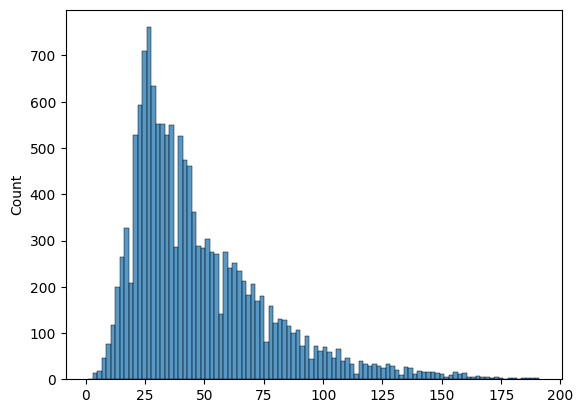

In [14]:
# visualize token distribution
sns.histplot(descriptions_len, bins=100)

In [15]:
embedding_fn = SentenceTransformerEmbeddingFunction()

In [16]:
# persistent
chroma_db = chromadb.PersistentClient(path="db")

In [17]:
chroma_db.list_collections()

[]

In [18]:
# Get / Create Collection
chroma_collection = chroma_db.get_or_create_collection(
    "movies", embedding_function=embedding_fn
)

In [19]:
chroma_db.list_collections()

[Collection(name=movies)]

In [20]:
# add all tokens to collection
ids = [str(i) for i in df_movies_filt["id"].tolist()]
documents = df_movies_filt["overview"].tolist()
titles = df_movies_filt["title"].tolist()
metadatas = [{"source": title} for title in titles]

In [21]:
len(ids)

14501

In [22]:
chroma_collection.add(documents=documents, ids=ids, metadatas=metadatas)

In [23]:
# count of documents in collection
len(chroma_collection.get()["ids"])

14501

In [26]:
# Save the chroma collection
# Run a Query
def get_title_by_description(query_text: str):
    n_results = 5
    res = chroma_collection.query(query_texts=[query_text], n_results=n_results)
    for i in range(n_results):
        pprint(f"Title: {res['metadatas'][0][i]['source']}")
        pprint(f"Description: {res['documents'][0][i]}")
        pprint("-------------------------------------------------")

In [27]:
# Run a Query
get_title_by_description(query_text="spider hero")

'Title: Spider-Man: Across the Spider-Verse'
('Description: After reuniting with Gwen Stacy Brooklyn’s full-time friendly '
 'neighborhood Spider-Man is catapulted across the Multiverse where he '
 'encounters the Spider Society a team of Spider-People charged with '
 'protecting the Multiverse’s very existence. But when the heroes clash on how '
 'to handle a new threat Miles finds himself pitted against the other Spiders '
 'and must set out on his own to save those he loves most.')
'-------------------------------------------------'
'Title: Spider-Man: Homecoming'
('Description: Following the events of Captain America: Civil War Peter Parker '
 'with the help of his mentor Tony Stark tries to balance his life as an '
 'ordinary high school student in Queens New York City with fighting crime as '
 'his superhero alter ego Spider-Man as a new threat the Vulture emerges.')
'-------------------------------------------------'
'Title: What if Noah Baumbach Directed Spider-Man?'
'Descripti